# Introduction

## Data Source

* Please download your heart rate data from https://stila.pms.ifi.lmu.de
* Pick a day from the overview calendar, be aware that you don't pick an event
* Click the "Download HR data" button to download the heart rate data

## Packages
use pip3 to install the following package
```python
pip3 install numpy
pip3 install SciPy
pip3 install matplotlib
```

## Location of the heart rate raw data

For further analysis, please save the heart rate raw data in the **"dataSource"** directory

Please run the following cell to see your heart rate data

## Assignment 1 (Input Data)
* Download your heart rate data from https://stila.pms.ifi.lmu.de
* put the heartrate_2016-XX-XX.csv file in to the dataSource folder
* change the filename to your downloaded csv file

In [51]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import os
import csv
import datetime as dt

# enable matplotlib inline codes
# %matplotlib inline
%matplotlib notebook
# allow interactions

### Assignment 1
### Please only replace the filename with the name of your csv file
filename = 'heartrate_2016-10-05.csv'

### Don't change the following code in this cell.

# Get the current working directory
currentDir=os.getcwd()

heartRateFile = os.path.abspath(os.path.join(currentDir,'dataSource',filename))
if os.path.exists(heartRateFile):
    print('Oberserving HeartRateFile Path is:\n%s' %(heartRateFile))
else:
    raise Exception(
      'File %s \n does not exist!' %(heartRateFile)
    )

Oberserving HeartRateFile Path is:
/Users/yingding/VCS/github/hc17ss/DataAnalysis1/dataSource/heartrate_2016-10-05.csv


In [52]:
def parseCSV(file, coding='utf-8'):
    # a possible encoding can be 'iso-8859-15'
    with open(file, 'r', encoding=coding) as csvfile:
        reader = csv.reader(csvfile)
        content = list(reader)
        header = content.pop(0) # remove first header
    return header, content

hrHeader, hrContent = parseCSV(heartRateFile, 'utf-8') # with default windows encoding

print(hrHeader)
print('The Format of single HR Data: ', hrContent[0])
print("Loaded No. of Heart Rate Raw Data is: %d" %(len(hrContent)))

# The timestamp in data sets are your local utc timestamps
hrRaw = [heartrate for timestamp, heartrate in hrContent]
timestampRaw = [dt.datetime.fromtimestamp(int(timestamp)/1000) for timestamp, heartrate in hrContent]

#print(len(hrRaw))
#print(len(timestampRaw))
print('HR Data begins at: ',timestampRaw[0])
print('HR Data stops at: ',timestampRaw[-1])
print(type(timestampRaw[0]))

['\ufeff"timestamp"', 'heartrate']
The Format of single HR Data:  ['1475623760000', '70']
Loaded No. of Heart Rate Raw Data is: 4285
HR Data begins at:  2016-10-05 01:29:20
HR Data stops at:  2016-10-05 23:16:20
<class 'datetime.datetime'>


## Examing Heart Rate Raw Data
the following sections uses plots to examing heart rate raw data

<IPython.core.display.Javascript object>


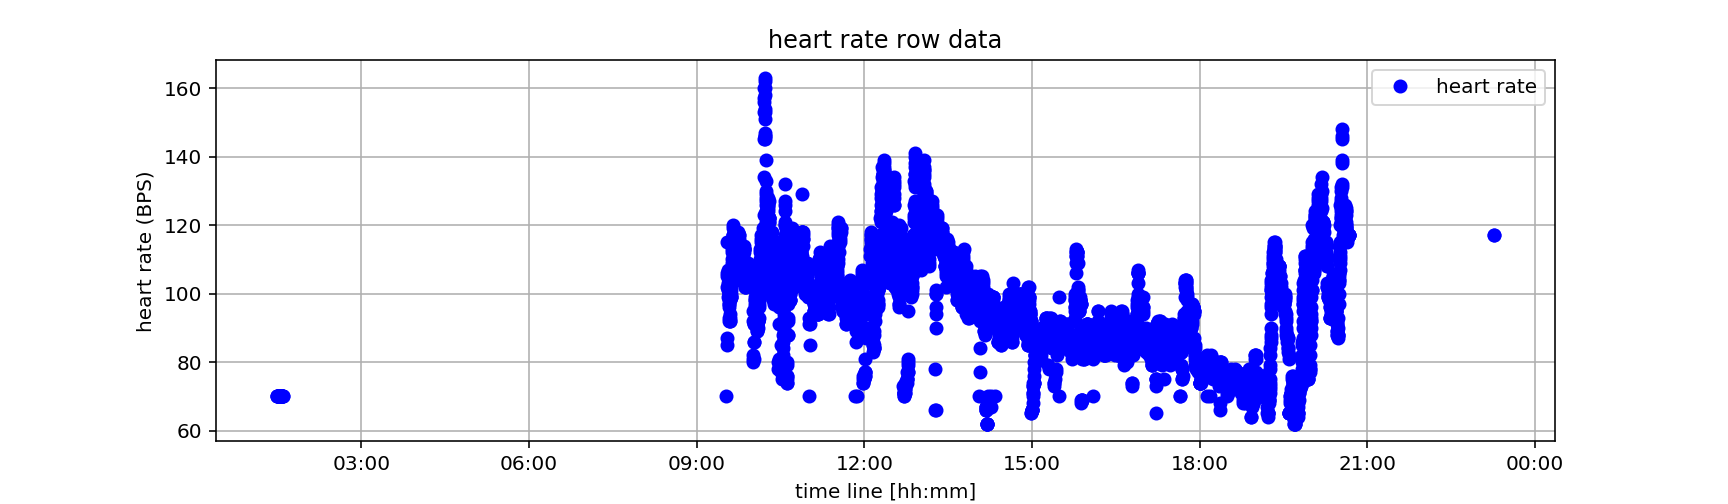

In [105]:
## show plot interactive, if you want inline, comment out this line.
# %matplotlib auto

def plotingSimple(xvals, yvals, xlabel_str, ylabel_str, title, style):
    """
    creates a plot
    """
    # close all old plots
    plt.close("all")
    # plotting
    plt.plot(xvals, yvals, style)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)    
    plt.title(title)
    # show the grid line/ help line in plot
    plt.grid(True)
    #plt.legend(loc='upper right')
    #plt.axis([0, 210, 0, 0.04 ])
    #plt.figure(figsize=[9,6])
    plt.show()
    
def ploting(xvals, yvals, xlabel_str, ylabel_str, title, style, label, grid=True):
    """
    creates a plot
    """
    # close all old plots
    plt.close("all")
    # plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(12,3.5) # you can set it to 15, 3.5 to make the cell width longer
    ax.plot_date(xvals, yvals, style, label=label)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    myFormatter = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(myFormatter)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)    
    plt.title(title)
    # show the grid line/ help line in plot
    plt.grid(grid)
    #plt.legend(loc='upper right')
    #plt.axis([0, 210, 0, 0.04 ])
    #plt.figure(figsize=[9,6])
    plt.show()    
   
## Main activity and time

xlabel_str = "time line [hh:mm]"
ylabel_str = "heart rate (BPS)"
title = "heart rate row data"
label = "heart rate"

# shows a point plot
# style can be bo-
ploting(timestampRaw,hrRaw, xlabel_str, ylabel_str, title, 'bo', label, True)


<IPython.core.display.Javascript object>


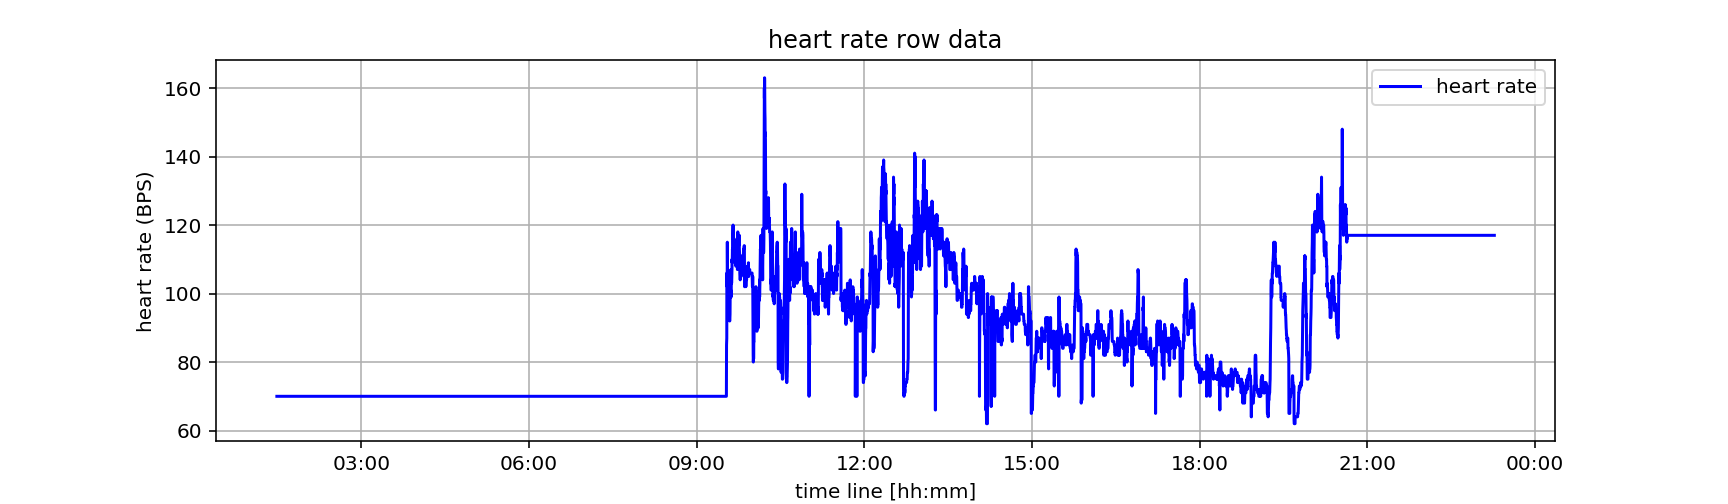

In [106]:
# shows a line plot
ploting(timestampRaw,hrRaw, xlabel_str, ylabel_str, title, 'b-', label, True)

In [107]:
plt.close('all')

## Segmenting the heart rate raw data
* segments heart rate raw data to 10 minutes segments
* for each segments, the heart rate feature is calculated.

In [108]:
def getBeginTimestamp(datetime):
    """
    this method returns the timestampe of the day by the given datetime.
    If the given datetime is 2016-10-05 01:29:20
    this method returns the timestamp of 2016-10-05 00:00:00
    """
    # extract the date string from the given datetime object
    str_current_date = dt.datetime.strftime(datetime, '%Y-%m-%d')
    # print("Current Observed Date: ",str_current_date)
    # convert the extracted date string to datetime object
    currentDate = dt.datetime.strptime(str_current_date, '%Y-%m-%d')
    # get the utc timestamp of the date string of the given datetime object
    int_ts_currentDate = int(dt.datetime.timestamp(currentDate))
    return int_ts_currentDate;

def getDateStr(datetime):
    """
    this method returns the date string of the given datetime object
    If the given datetime is 2016-10-05 01:29:20
    this method returns the date string 2016-10-05
    """
    return dt.datetime.strftime(datetime, '%Y-%m-%d')
     
#current date timestamp
curDateTS = getBeginTimestamp(timestampRaw[0]) 
print("timestamp of current Date: " , curDateTS)

# list of timestamps saved in int
intTimestampRaw = [int(int(timestamp)/1000) for timestamp, heartRate in hrContent]

def segmentingDate(intTimestampRaw, hrRaw, curDateTS): 
    """
    this method make 10 minutes segments from heart rate raw data
    """
    segments = {}
    deliminator = 10 * 60
    segment_id = 0
    for id in range(len(intTimestampRaw)):
        timestamp = intTimestampRaw[id]
        heartrate = int(hrRaw[id])
        segment_id = (timestamp - curDateTS) // deliminator
        segment_label = segment_id * deliminator + curDateTS
        segments.setdefault(segment_label,[]).append(heartrate)
    return segments

# segments is a dictionary with segment timestamp as key, 
# and all heart rate values of the segment is saved as value
# in the segment dictionary
segments = segmentingDate(intTimestampRaw, hrRaw, curDateTS)


segments_labels = []
for label in segments.keys():
    segments_labels.append(int(label))
# in place sorting
list.sort(segments_labels)     
    
print("The number of total parsed segments is: ", len(segments))




timestamp of current Date:  1475618400
The number of total parsed segments is:  71


In [109]:
# clearing the data
# it is assumed that at each 10 minutes segment 
# at least 30 measurements shall be obtained,
# otherwise the segment is not valid for further usage

def cleanData(segments, debugging):
    clean_list = []
    for label, segment in segments.items():
        if len(segment) < 30:
            clean_list.append(label)
    if debugging:         
        print("Need to be cleaned labels are:", clean_list)
        for label in clean_list:
            print(segments[label])
    for label in clean_list:
        del segments[label]        

cleanData(segments, False)    

print("The number of valid segments is: ", len(segments))

The number of valid segments is:  67


In [110]:
# Making a index of the segments labels
segments_labels = []
for label in segments.keys():
    segments_labels.append(int(label))
# in place sorting
list.sort(segments_labels)

## Examing a sample segment
plots a sample segment

<IPython.core.display.Javascript object>


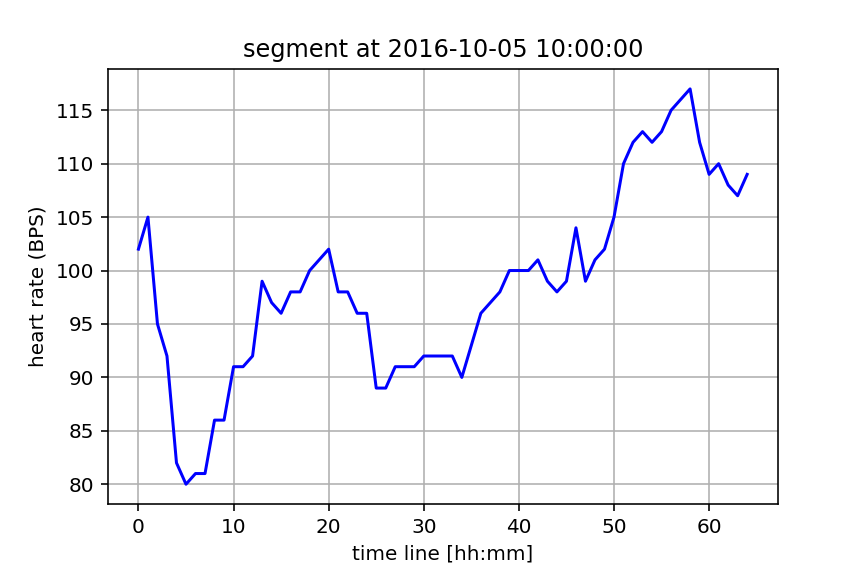

In [111]:
# Display segments
def displaySegment(idx):
    segment_label = segments_labels[idx]
    segment_str = str(dt.datetime.fromtimestamp(segment_label))
    # print("ploting segement with label: ", segment_str)
    segment = segments[segment_label]
    # print(segment)
    plotingSimple(range(len(segment)),segment, xlabel_str, ylabel_str, "segment at "+ segment_str, 'b-')

displaySegment(3)

## Example of featureCalculation function
the following featureCalculation function calculates the meanHR feature

* meanHR: the mean of the heart rate within a segment

Note: 

The following meanHR plot shall be very similar to the stila portal's heart rate plot, since the stila portal's plot does the mean aggregation of heart rates automatically while zooming. 

In [124]:
# this function calculates the heart rate value within a segment
# the type of heart rate value within the segment is integer
def featureCalculation_meanHR(segment):
    return np.mean(segment)

<IPython.core.display.Javascript object>


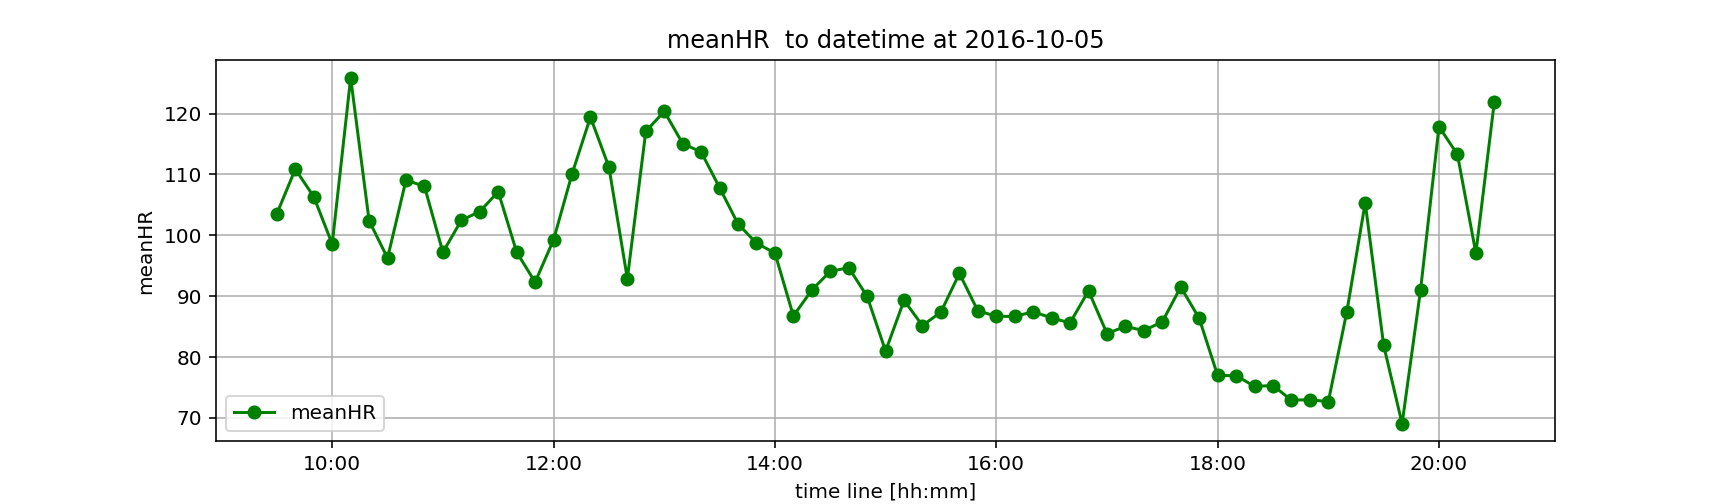

In [134]:
# enable matplotlib inline codes
# %matplotlib inline

# Ploting the segments
featureName = "meanHR"
title = "meanHR  to datetime"

def displayFeature(featureCalculation, featureName, title, style):
    sub_title = title + " at " + getDateStr(dt.datetime.fromtimestamp(int(segments_labels[0])))
    featureValues = [featureCalculation(segments[segment_label]) for segment_label in segments_labels]
    labelValues = [dt.datetime.fromtimestamp(segment_label) for segment_label in segments_labels]
    ploting(labelValues, featureValues, 'time line [hh:mm]', featureName, sub_title, style, featureName, True)

displayFeature(featureCalculation_meanHR, featureName, title, 'go-')    

## This meanHR plot shall be very similar 
## to the stila portal's heart rate plot

## Assignment 2 (featureCalculation function)
* meanRR: mean of the RR-interval
* RR = 60/ HR


In [135]:
# template function, adapt it to your heart rate feature
# this function calculates meanRR
# RR = 60/HR
# meanRR should display a reverse line plot to meanHR line plot

def featureCalculation_meanRR(segment):
    return np.mean([60/value for value in segment])

## Assignment 3 (plotting features)
You shall only modify
* the name of your feature
* title of the plot

In [136]:
# enable matplotlib auto codes
%matplotlib auto

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


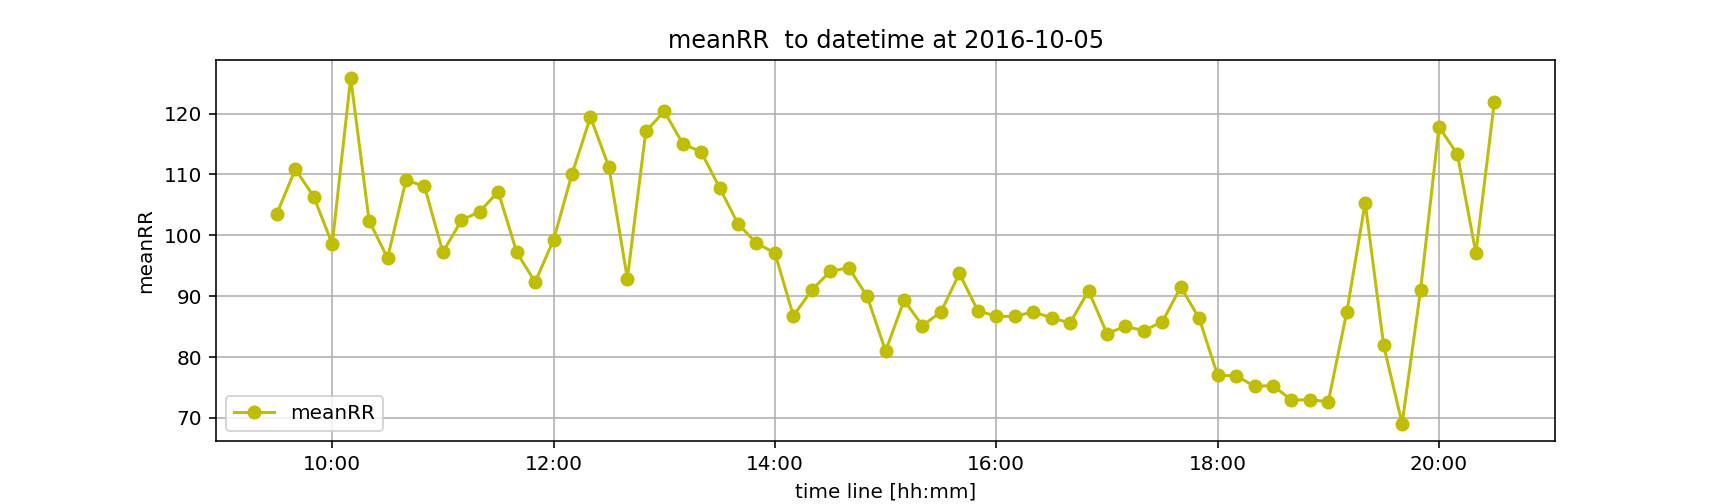

In [137]:
# Ploting the segments
featureName = "meanRR"
title = "meanRR  to datetime"
## You don't need to change this section for complete the assigment
displayFeature(featureCalculation_meanHR, featureName, title, 'yo-')

# Analyzing heart rate variability 4 (HRV)
* one way to express HRV is using the time domain feature RMSSD

In [138]:
def featureCalculation_RR(segment):
    """
    Takes a Segment of hrValues
    Transforms them to rrValues
    """
    return [60/hrValue for hrValue in segment]

def featureCalculation_SqDiff(segment):
    """
    Takes a Segment of rrValues
    Calculates the squared difference of adjacent RR-intervals
    """
    list = []
    for i in range(0,len(segment)-1):
        list.append(np.square(segment[i+1]-segment[i]))
    return list;

def featureCalculation_RMSSD(segment):
    """
    Takes a Segment of hrValues
    Transforms them to rrValues
    Calculates the squared difference of adjacent RR-intervals
    Calculates the mean value
    Calculates the square root  
    """
    return np.sqrt(np.mean(featureCalculation_SqDiff(featureCalculation_RR(segment))))

def featureCalculation_SDRR(segment):
    """
    Takes a Segment of hrValues
    Transforms them to rrValues
    Calculates the standard deviation
    """
    return np.std(featureCalculation_RR(segment))

def featureCalculation_MeanRR(segment):
    """
    Takes a Segment of hrValues
    Transforms them to rrValues
    Calculates the mean value
    """
    return np.mean(featureCalculation_RR(segment))

<IPython.core.display.Javascript object>


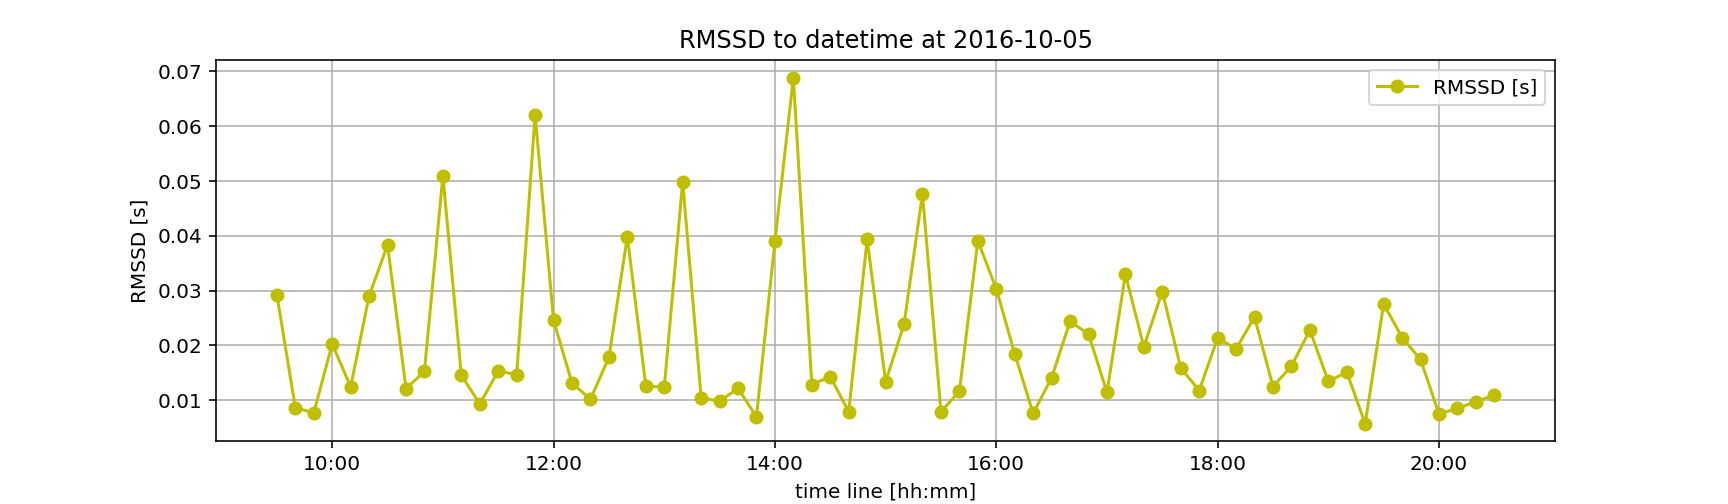

In [139]:
# Ploting the segments
featureName = "RMSSD [s]"
title = "RMSSD to datetime"
## You don't need to change this section for complete the assigment
displayFeature(featureCalculation_RMSSD, featureName, title, 'yo-')